# Differential Expression Analysis for CCC & Downstream Signalling Networks
[According to the liana docs](https://liana-py.readthedocs.io/en/latest/notebooks/targeted.html)
- Developed by: Christian Eger
- Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg
- Created on: 240311
- Last modified: 240325<br>

# Differential Expression Analysis for CCC & Downstream Signalling Networks

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
import omnipath as op

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

/tmp/ipykernel_859211/3877725334.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
adata = sc.read_h5ad("/mnt/LaCIE/ceger/Projects/COPD/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad")
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

Define columns of interest from `.obs`

Note that we use cell abbreviations because MOFA will use them as labels for the views.

In [3]:
sample_key = 'batch'
groupby = 'cell_compartment'
condition_key = 'group'

### Basic QC

In [4]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

## Differential Testing

First, we need to generate pseudobulk profiles for each cell type, and we do so using the [`decoupler` package](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html). 

In [5]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 214 × 27191
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'batch', 'percent_mt2', 'percent_chrY', 'condition', 'sample_group', 'group', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'n_cells'
    layers: 'psbulk_props'

/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


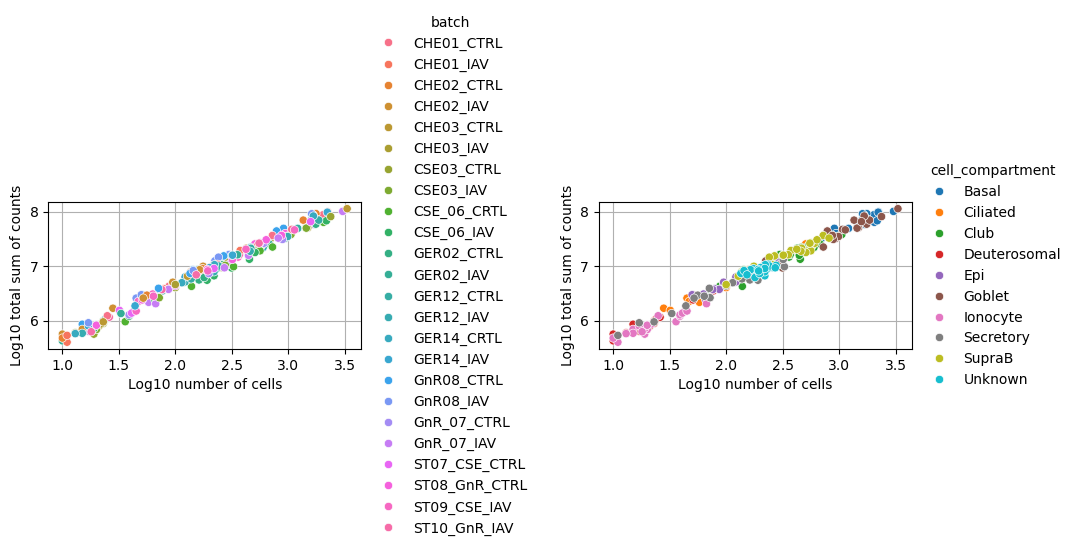

In [6]:
dc.plot_psbulk_samples(pdata, groupby=[sample_key, groupby], figsize=(11, 4))

## Differential Expression Analysis

In [7]:
%%capture

dea_results = {}
quiet = True
conditions = pdata.obs.group.unique().tolist()

for cell_group in pdata.obs[groupby].unique():
    print(cell_group)
    if pdata.obs.query('cell_compartment == @cell_group').group.unique().tolist() == conditions:
        # Select cell profiles
        
        ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
        print(ctdata.obs.group.unique())

        # Obtain genes that pass the edgeR-like thresholds
        # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
        genes = dc.filter_by_expr(ctdata,
                                  group=condition_key,
                                  min_count=5, # a minimum number of counts in a number of samples
                                  min_total_count=10 # a minimum total number of reads across samples
                                  )

        # Filter by these genes
        ctdata = ctdata[:, genes].copy()

        # Build DESeq2 object
        # NOTE: this data is actually paired, so one could consider fitting the patient label as a confounder

        dds = DeseqDataSet(
            adata=ctdata,
            design_factors=condition_key,
            ref_level=[condition_key, 'copd_ctrl'], # set control as reference
            refit_cooks=True,
            quiet=quiet
        )

        # Compute LFCs
        dds.deseq2()
        # Contrast between stim and ctrl
        stat_res = DeseqStats(dds, contrast=[condition_key, 'copd-iav', 'copd-ctrl'], quiet=quiet)
        stat_res.quiet = quiet
        # Compute Wald test
        stat_res.summary()
        # Shrink LFCs
        stat_res.lfc_shrink(coeff='group_copd-iav_vs_copd-ctrl') # {condition_key}_cond_vs_ref

        dea_results[cell_group] = stat_res.results_df

/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/pydeseq2/utils.py:1245: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/pydeseq2/utils.py:1245: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/pydeseq2/utils.py:1245: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/pydeseq2/utils.py:1245: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/pydeseq2/utils.py:1245: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home

In [8]:
dea_df = pd.concat(dea_results)
dea_df = (
    dea_df
    .reset_index()
    .rename(
        columns={
            'level_0': groupby,
            'level_1': 'index',
        }
    )
    .set_index('index')
)
dea_df.head()

,cell_compartment,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,,
A1BG,Basal,64.594406,-2.512258e-06,0.000859,-1.166222,0.243525,0.999961
A1BG-AS1,Basal,58.376438,7.471405e-07,0.000834,-0.008946,0.992862,0.999961
A1CF,Basal,4.516191,-3.367467e-06,0.000837,-0.783964,0.433061,0.999961
A2M,Basal,8.660245,-1.935273e-06,0.000887,-1.532309,0.125446,0.999961
A2M-AS1,Basal,8.783511,-1.549825e-06,0.000851,-0.819210,0.412667,0.999961


## DEA to Ligand-Receptor Interactions

In [9]:
adata = adata[adata.obs[condition_key]=='copd_ctrl'].copy()

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [11]:
lr_res = li.multi.df_to_lr(adata,
                           dea_df=dea_df,
                           resource_name='consensus',
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

Using resource `consensus`.
Using `.X`!
78 features of mat are empty, they will be removed.
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
['NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1', 'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'NC_026438.1'] contain `_`. Consider replacing those!
0.25 of entities in the resource are missing from the data.


In [12]:
lr_res = lr_res.sort_values("interaction_stat", ascending=False, key=abs)
lr_res.head()

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_pvalue,ligand_padj,ligand_expr,ligand_props,...,receptor_pvalue,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_pvalue,interaction_padj,interaction_expr,interaction_props,interaction
43370,LGALS9,CD47,LGALS9,CD47,SupraB,3.975413,7.025722e-05,1.105407e-02,0.467342,0.706086,...,2.759109e-05,0.002165,0.655885,0.852593,4.083951,0.000049,0.006609,0.561613,0.779340,LGALS9^CD47
1918,LGALS9,CD47,LGALS9,CD47,Basal,3.960716,7.472540e-05,1.418343e-02,0.236511,0.386861,...,2.759109e-05,0.002165,0.655885,0.852593,4.076602,0.000051,0.008174,0.446198,0.619727,LGALS9^CD47
20028,SLPI,PLSCR1,SLPI,PLSCR1,Club,2.434675,1.490517e-02,1.801195e-01,4.035388,1.000000,...,1.136238e-08,0.000006,0.456492,0.770031,4.071851,0.007453,0.090063,2.245940,0.885015,SLPI^PLSCR1
51489,CXCL10,SDC4,CXCL10,SDC4,Unknown,6.035888,1.580908e-09,8.092718e-07,0.029267,0.100152,...,4.274605e-02,0.324135,1.161776,0.969973,4.031035,0.021373,0.162068,0.595522,0.535062,CXCL10^SDC4
20924,SLPI,PLSCR1,SLPI,PLSCR1,Club,2.434675,1.490517e-02,1.801195e-01,4.035388,1.000000,...,6.794183e-08,0.000020,0.647323,0.825493,3.915603,0.007453,0.090070,2.341356,0.912747,SLPI^PLSCR1


## Visualize the Results

<Axes: >

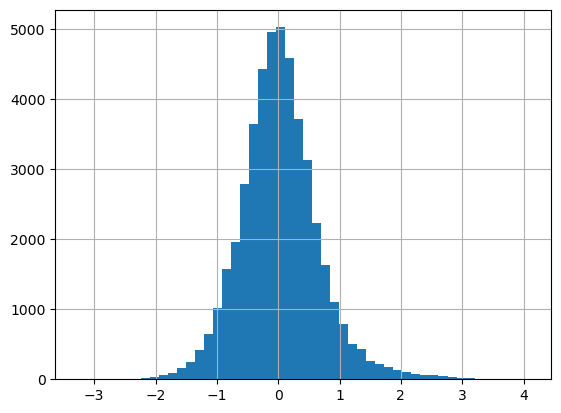

In [13]:
# Let's visualize how this looks like for all interactions  (across all cell types)
lr_res = lr_res.sort_values("interaction_stat", ascending=False)
lr_res['interaction_stat'].hist(bins=50)

/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1328 rows containing missing values.
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


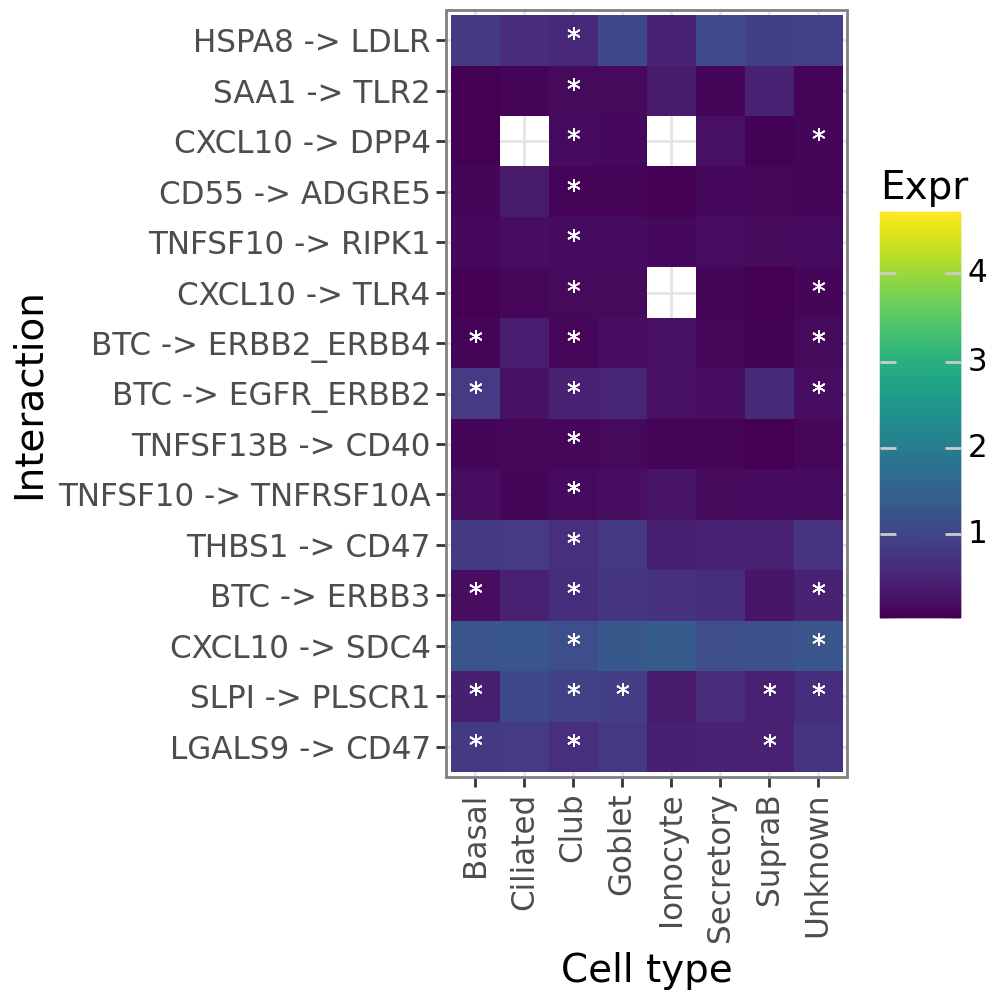

In [14]:
li.pl.tileplot(liana_res=lr_res,
               fill = 'expr',
               label='padj',
               label_fun = lambda x: '*' if x < 0.05 else np.nan,
               top_n=15,
               orderby = 'interaction_stat',
               orderby_ascending = False,
               orderby_absolute = False,
               source_title='Ligand',
               target_title='Receptor',
               )

### Ligand-Receptor Plot

/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/plotnine/scales/scale.py:130: PlotnineWarning: scale_color_cmap could not recognise parameter `midpoint`
/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


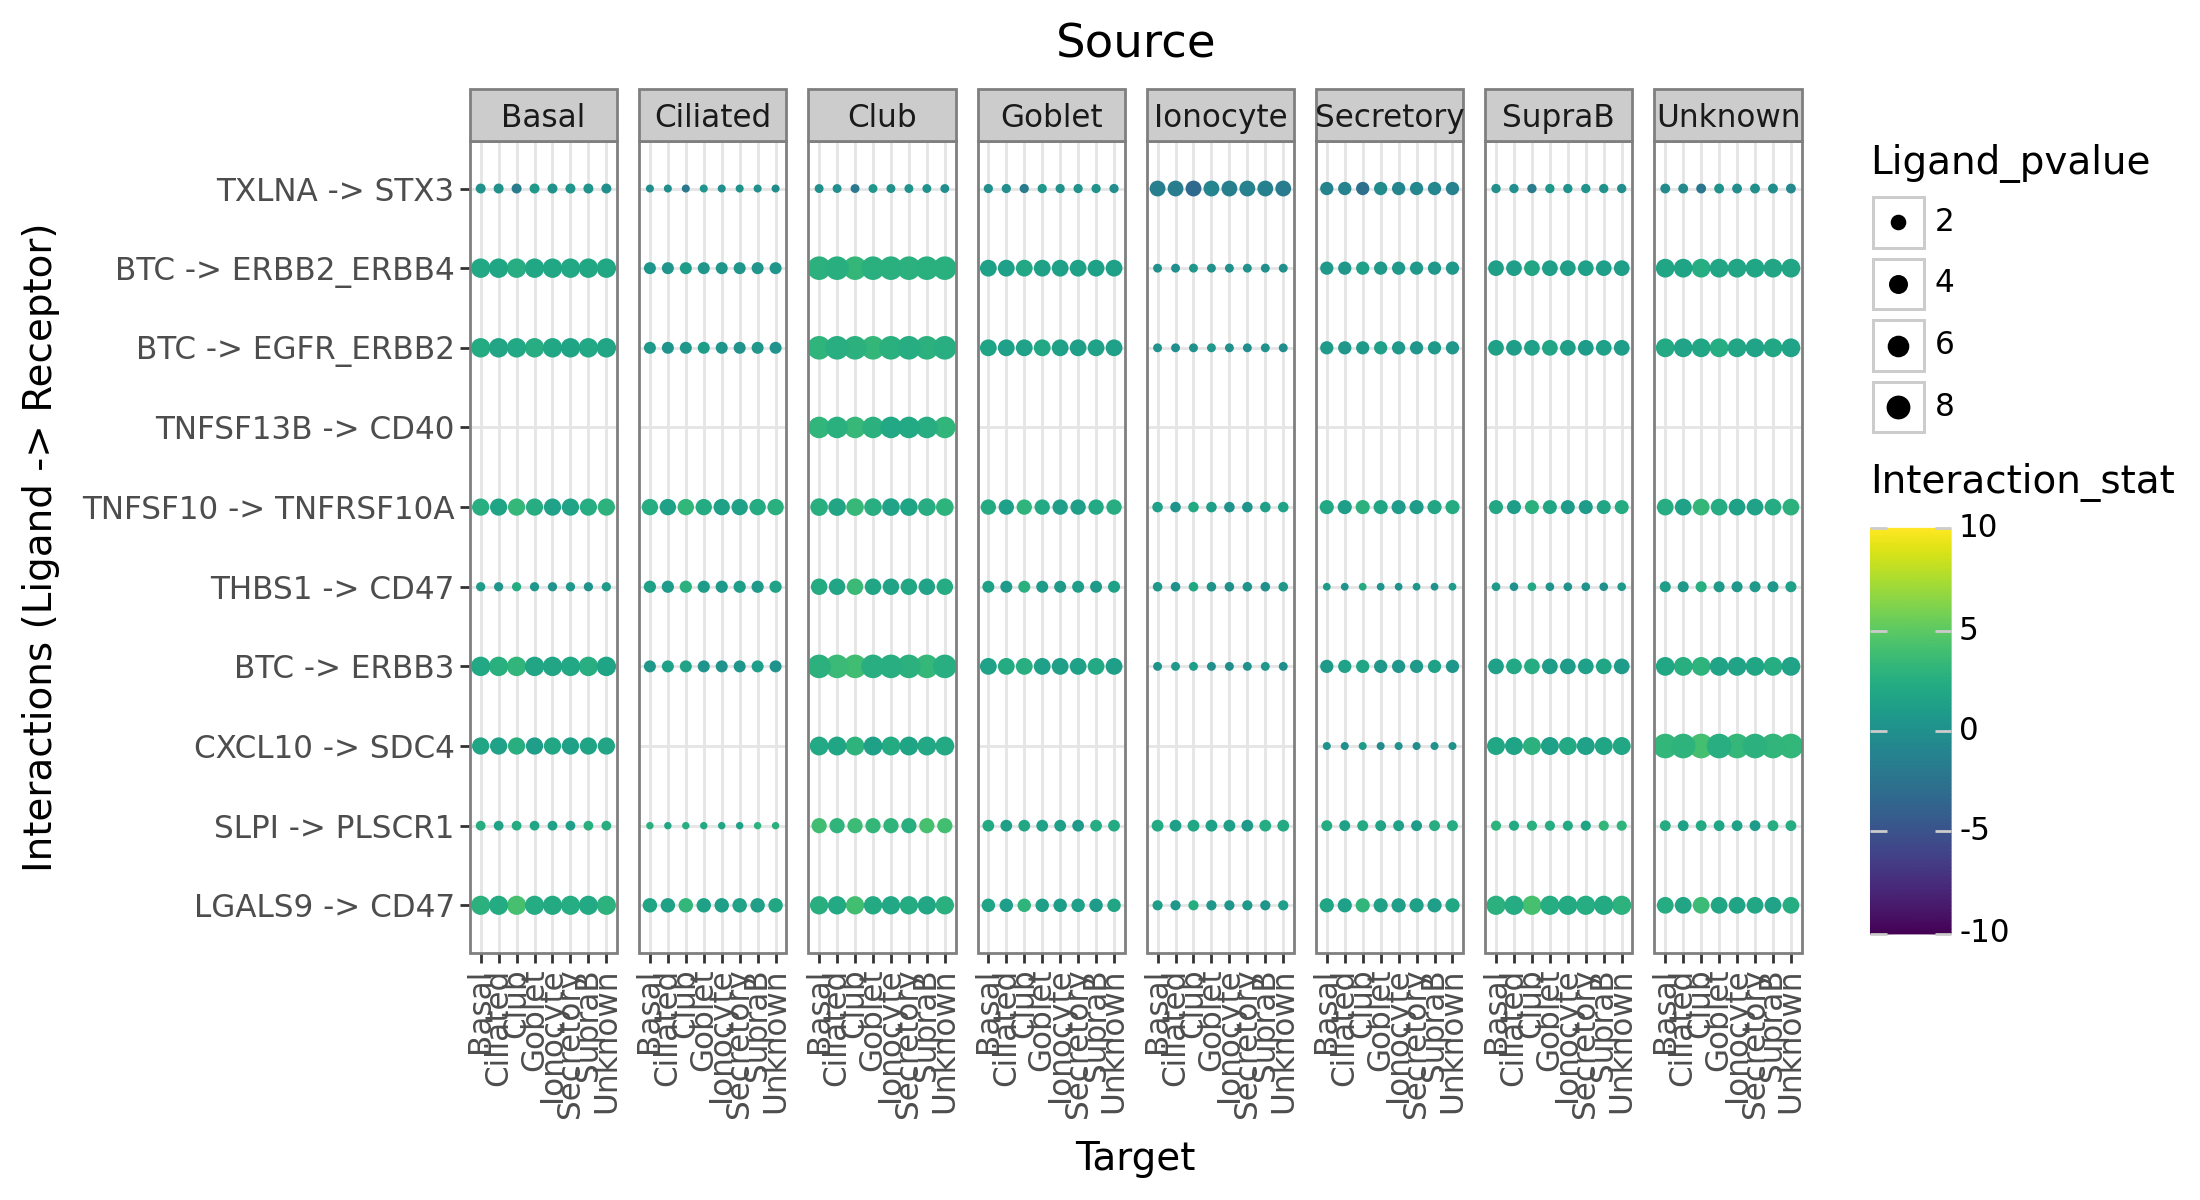

In [15]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='ligand_pvalue',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=10,
                     size_range=(0.5, 4)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, with 0 the middle
    + p9.scale_color_cmap(midpoint=0, limits=(-10, 10))
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(11, 6))

)

## Intracellular Signaling Networks

In [16]:
# utily function to select top n interactions
def select_top_n(d, n=None):
    d = dict(sorted(d.items(), key=lambda item: abs(item[1]), reverse=True))
    return {k: v for i, (k, v) in enumerate(d.items()) if i < n}

### Select Cell types of Interest

In [17]:
adata.obs[groupby].unique().tolist()

['Ciliated',
 'Deuterosomal',
 'Club',
 'Unknown',
 'Basal',
 'Goblet',
 'Secretory',
 'Ionocyte',
 'SupraB',
 'Epi']

In [18]:
source_label = 'Club'
target_label = 'Goblet'

# NOTE: We sort by the absolute value of the interaction stat
lr_stats = lr_res[lr_res['source'].isin([source_label]) & lr_res['target'].isin([target_label])].copy()
lr_stats = lr_stats.sort_values('interaction_stat', ascending=False, key=abs)

In [19]:
lr_dict = lr_stats.set_index('receptor')['interaction_stat'].to_dict()
input_scores = select_top_n(lr_dict, n=5)

In [20]:
def return_receptor_stats(cell_labels):
    lr_stats_dict = {}
    lr_dict_dict = {}
    input_scores_dict = {} 
    for label in cell_labels:
        source_label = label
        for label in cell_labels:
            target_label = label
            key = source_label + '_' + target_label
            lr_stats = (
                lr_res[
                    lr_res['source']
                    .isin([source_label])
                    &
                    lr_res['target']
                    .isin([target_label])
                ]
                .copy()
                .sort_values(
                    'interaction_stat',
                    ascending=False,
                    key=abs
                )
            )
            lr_dict = (
                lr_stats
                .set_index('receptor')['interaction_stat']
                .to_dict()
            )
            input_scores = select_top_n(lr_dict, n=5)

            lr_stats_dict[key] = lr_stats
            lr_dict_dict[key] = lr_dict
            input_scores_dict[key] = input_scores
    return(lr_stats_dict, lr_dict_dict, input_scores_dict)

In [21]:
labels = ['Club', 'Goblet', 'Basal']

lr_stats_dict, lr_dict_dict, input_scores_dict = return_receptor_stats(labels)

In [22]:
input_scores_dict['Club_Basal']

{'PLSCR1': 3.862539217937486,
 'CD40': 3.1149019913690483,
 'ERAP1': 2.7046618706338705,
 'TNFRSF10A': 2.6254426456283237,
 'ADGRE5': 2.3393118315794523}

### Select Transcription Factors of interest

In [23]:
# First, let's transform the DEA statistics into a DF
# we will use these to estimate deregulated TF activity
dea_wide = dea_df[[groupby, 'stat']].reset_index(names='genes').pivot(index=groupby, columns='genes', values='stat')
dea_wide = dea_wide.fillna(0)
dea_wide

genes,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,AAAS,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
cell_compartment,,,,,,,,,,,,,,,,,,,,,
Basal,-1.166222,-0.008946,-0.783964,-1.532309,-0.819210,0.535441,-0.296206,-0.385175,-0.073882,-0.009897,...,0.119275,0.630725,0.759152,0.062875,-0.068466,0.063195,0.636743,-0.251530,0.027405,-0.291116
Ciliated,-0.031502,-0.200805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093432,-0.487144,...,-0.625076,0.935665,-0.367559,0.000000,-0.312078,-0.418258,-1.297685,-0.585186,-0.390164,0.135635
Club,0.000000,0.000000,0.000000,0.000000,0.000000,-0.862902,0.000000,0.000000,0.098618,-1.326848,...,-0.923904,1.186618,-0.126824,0.706774,-1.099363,-0.335957,1.406766,0.086781,-1.403075,-0.102363
Goblet,1.045565,0.597092,0.000000,0.000000,-0.046399,1.231902,0.112749,0.400151,0.329608,-0.974887,...,0.375964,-0.287641,0.283785,0.414108,0.024338,0.097564,1.186042,-0.160291,0.448657,-0.792672
Ionocyte,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.141591,-0.085536,...,0.210512,0.216298,-1.445248,0.000000,0.096734,-0.037897,0.000000,1.085379,-0.250773,-1.310056
Secretory,0.000000,0.000000,0.000000,0.000000,0.000000,-0.811097,0.000000,0.000000,0.444814,0.908286,...,0.671197,-0.889027,-0.442806,-0.460700,0.031029,0.359566,0.000000,-1.332821,1.349616,-1.021261
SupraB,-1.453626,-0.373390,0.000000,0.000000,0.000000,1.220932,0.000000,0.000000,0.312231,-1.087842,...,-0.140996,0.416443,0.590148,-0.652845,1.190500,0.005096,-1.266166,0.814307,-0.436254,-0.490837
Unknown,0.598122,0.048314,0.000000,0.000000,0.000000,-0.574001,0.000000,0.000000,0.217234,0.635776,...,0.906773,-0.185605,1.099098,0.580785,0.099509,-0.056155,0.000000,-2.253572,0.153348,0.094266


In [24]:
# Obtain TF regulons
net = dc.get_collectri()
# Run Enrichment Analysis
estimates, pvals = dc.run_ulm(mat=dea_wide, net=net)
estimates.T.sort_values(target_label, key=abs, ascending=False).head()

,Basal,Ciliated,Club,Goblet,Ionocyte,Secretory,SupraB,Unknown
STAT1,16.310562,10.198027,9.978024,14.685658,7.705266,8.560119,16.508430,16.491955
IRF1,15.163647,9.347089,13.211065,14.679414,4.863367,5.785237,13.045841,14.922425
IRF9,12.575990,10.871125,7.971632,11.250916,8.248324,8.874924,12.527434,12.557594
STAT2,12.112165,6.397645,9.230292,10.654691,7.212506,6.412819,11.843542,12.695624
IRF2,11.514891,7.486773,9.211061,9.663326,4.126212,3.912529,10.382861,12.383841


### Select top TFs

In [25]:
def return_output_scores(cell_labels):
    output_scores_dict = {}
    for label in cell_labels:
        source_label = label
        for label in cell_labels:
            target_label = label
            key = source_label + '_' + target_label
            tf_data = estimates.copy()
            tf_dict = (
                tf_data
                .loc[target_label]
                .to_dict()
            )
            output_scores = select_top_n(tf_dict, n=10)
            output_scores_dict[key] = output_scores
    return output_scores_dict

return_output_scores(labels)['Club_Club']

{'IRF1': 13.211065292358398,
 'NFKB1': 11.046988487243652,
 'STAT1': 9.978023529052734,
 'RELA': 9.639533996582031,
 'STAT2': 9.230292320251465,
 'IRF2': 9.211061477661133,
 'IRF9': 7.971632480621338,
 'REL': 7.714064598083496,
 'NFKB': 7.060591220855713,
 'SREBF2': 6.820725440979004}

In [26]:
tf_data = estimates.copy()
tf_dict = tf_data.loc[target_label].to_dict()
output_scores = select_top_n(tf_dict, n=10)

### Generate a Prior Knowledge Network

In [27]:
# obtain ppi network
ppis = op.interactions.OmniPath().get(genesymbols = True)

ppis['mor'] = ppis['is_stimulation'].astype(int) - ppis['is_inhibition'].astype(int)
ppis = ppis[(ppis['mor'] != 0) & (ppis['curation_effort'] >= 5) & ppis['consensus_direction']] 

input_pkn = ppis[['source_genesymbol', 'mor', 'target_genesymbol']]
input_pkn.columns = ['source', 'mor', 'target']
input_pkn.head()

,source,mor,target
3,CAV1,1,TRPC1
6,ITPR2,1,TRPC1
9,STIM1,1,TRPC1
10,TRPC1,1,TRPC3
11,TRPC3,1,TRPC1


In [28]:
# convert the PPI network into a knowledge graph
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (3115, 6157)
 - Provided inputs included in the prior network: 4/5
 - Provided outputs included in the network: 9/10
Performing reachability analysis...
done.
 - Selected inputs: 2/4.
 - Selected outputs: 7/9.
 - Final size of the prior graph: (529, 1988).


### Calculate Node weights

In [29]:
temp = adata[adata.obs[groupby] == target_label].copy()

In [30]:
node_weights = pd.DataFrame(temp.X.getnnz(axis=0) / temp.n_obs, index=temp.var_names)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()

### Find Causal Network


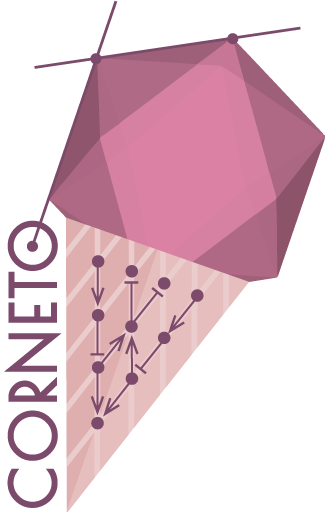

In [31]:
import corneto as cn
cn.info()

In [32]:
df_res, problem = li.mt.find_causalnet(
    prior_graph, 
    input_scores, 
    output_scores, 
    node_weights,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1, 
    max_penalty=1,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.01,
    edge_penalty=0.1,
    verbose=True,
    solver='scipy', # NOTE scipy's solver might results in suboptimal solutions
    )

Total positive/negative scores of the inputs and outputs:
 - (-) input nodes: 0
 - (+) input nodes: 13.083504734368395
 - (-) output nodes: 0
 - (+) output nodes: 100.73258924484253
 - abs total (inputs + outputs): 113.81609397921092
Building CORNETO problem...
Solving with scipy...


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 25 11:49:18 AM: Your problem has 9603 variables, 31 constraints, and 0 parameters.
(CVXPY) Mar 25 11:49:18 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 25 11:49:18 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 25 11:49:18 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 25 11:49:18 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 25 11:49:18 AM: Compiling problem (target solver=SCIPY).


/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/scipy/optimize/_milp.py:372: OptimizeWarning: Option "log_to_console" is "true", but only True or False is allowed. Using default: True.


Solver terminated with message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 25 11:49:24 AM: Problem status: optimal
Running HiGHS 1.2.0 [date: 2021-07-09, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
15993 rows, 9466 cols, 43840 nonzeros
14501 rows, 8394 cols, 44062 nonzeros

Solving MIP model with:
   14501 rows
   8394 cols (6234 binary, 0 integer, 0 implied int., 2160 continuous)
   44062 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%  

Done.
Solution summary:
 - Loss (unfitted inputs/output): [0.]
 - Edge penalty error: 30.0
 - Node penalty error: 0.0862168811248574


### Visualize the Inferred Network

In [33]:
df_res

,source,source_type,source_weight,source_pred_val,target,target_type,target_weight,target_pred_val,edge_type,edge_pred_val
0,CHUK,unmeasured,0.000000,1.0,CREBBP,unmeasured,0.000000,1.0,1,1.0
1,STAT2,unmeasured,0.000000,1.0,IRF9,output,11.250916,1.0,1,1.0
2,STAT1,unmeasured,0.000000,1.0,IRF1,output,14.679414,1.0,1,1.0
3,MAP3K1,unmeasured,0.000000,1.0,CHUK,unmeasured,0.000000,1.0,1,1.0
4,MAP2K1,unmeasured,0.000000,1.0,GSK3B,unmeasured,0.000000,1.0,1,1.0
5,STAT2,unmeasured,0.000000,1.0,STAT1,output,14.685658,1.0,1,1.0
6,CHUK,unmeasured,0.000000,1.0,IKBKB,unmeasured,0.000000,1.0,1,1.0
7,IKBKB,unmeasured,0.000000,1.0,IRF3,output,8.166336,1.0,1,1.0
8,CREBBP,unmeasured,0.000000,1.0,STAT2,output,10.654691,1.0,1,1.0
9,CREBBP,unmeasured,0.000000,1.0,RELA,output,8.906585,1.0,1,1.0


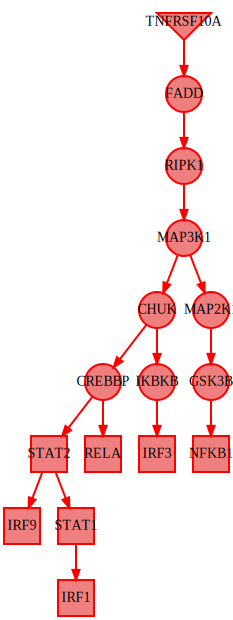

In [34]:
cn.methods.carnival.visualize_network(df_res)

### Change signalling cells in Network Visualization

In [37]:
# Potential Interactions based on constrained list
for label_1 in labels:
    for label_2 in labels:
        print(f'{label_1}_{label_2}')

Club_Club
Club_Goblet
Club_Basal
Goblet_Club
Goblet_Goblet
Goblet_Basal
Basal_Club
Basal_Goblet
Basal_Basal


Importing network...
done.
 - Nodes x Edges: (3115, 6157)
 - Provided inputs included in the prior network: 5/5
 - Provided outputs included in the network: 9/10
Performing reachability analysis...
done.
 - Selected inputs: 3/5.
 - Selected outputs: 7/9.
 - Final size of the prior graph: (530, 1997).
Total positive/negative scores of the inputs and outputs:
 - (-) input nodes: 0
 - (+) input nodes: 15.78029550457401
 - (-) output nodes: 0
 - (+) output nodes: 91.88397884368896
 - abs total (inputs + outputs): 107.66427434826298
Building CORNETO problem...
Solving with scipy...


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 25 11:49:24 AM: Your problem has 9646 variables, 31 constraints, and 0 parameters.
(CVXPY) Mar 25 11:49:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 25 11:49:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 25 11:49:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 25 11:49:24 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 25 11:49:24 AM: Compiling problem (target solver=SCIPY).


/home/ceger/miniforge3/envs/DEA-env/lib/python3.10/site-packages/scipy/optimize/_milp.py:372: OptimizeWarning: Option "log_to_console" is "true", but only True or False is allowed. Using default: True.


Solver terminated with message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Running HiGHS 1.2.0 [date: 2021-07-09, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 25 11:49:26 AM: Problem status: optimal
Presolving model
16043 rows, 9497 cols, 43974 nonzeros
14547 rows, 8429 cols, 44128 nonzeros

Solving MIP model with:
   14547 rows
   8429 cols (6256 binary, 0 integer, 0 implied int., 2173 continuous)
   44128 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%  

Done.
Solution summary:
 - Loss (unfitted inputs/output): [0.]
 - Edge penalty error: 31.0
 - Node penalty error: 0.08591341706650656


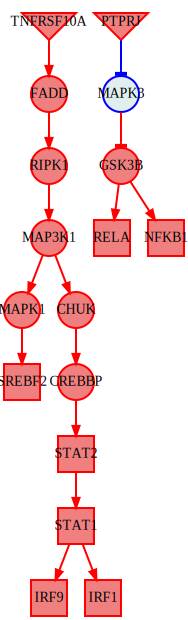

In [35]:
interaction = 'Club_Club'
input_scores = return_receptor_stats(labels)[2][interaction]
output_scores = return_output_scores(labels)[interaction]
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

df_res, problem = li.mt.find_causalnet(
    prior_graph, 
    input_scores, 
    output_scores, 
    node_weights,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1, 
    max_penalty=1,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.01,
    edge_penalty=0.1,
    verbose=True,
    solver='scipy', # NOTE scipy's solver might results in suboptimal solutions
    )
    
cn.methods.carnival.visualize_network(df_res)
